<a href="https://colab.research.google.com/github/eitt/cocoa/blob/main/%5BDI%5D_Biomass_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

---
By [Leonardo H. Talero-Sarmiento](https://apolo.unab.edu.co/en/persons/leonardo-talero)

---

This Notebook covers two approaches. The first is a code to download information from NASA Power database. The second is the calculation to extimate varaibles for the SIMPLE crop model

## Section 1: Retrieving Environmental Data from NASA Power Database

The first section of this Google Colab notebook focuses on retrieving a dataset of environmental characteristics from the NASA Power database. The dataset encompasses a range of parameters related to weather and climate, providing valuable information for analysis and research purposes. By utilizing the provided functions, you can access important data such as surface UVA irradiance, maximum and minimum temperatures at 2 meters, temperature range, and corrected precipitation. These functions streamline the process of retrieving and working with the NASA Power dataset, enabling users to easily access and utilize the environmental data in their analyses.

### Section 2: SIMPLE Crop Model Calculations

The second section of this Google Colab notebook centers around the implementation of functions related to the SIMPLE crop model calculations. These functions are specifically designed to provide insights and analysis in areas such as temperature effects, solar radiation, evapotranspiration, and water management. Each function serves a distinct purpose and takes in relevant parameters to generate meaningful outputs. By employing these functions, users can perform calculations related to temperature factors, heat stress levels, solar radiation effects on growth, reference evapotranspiration (ETO), adjusted crop evapotranspiration (ETC), and water factor (FWater). These calculations contribute to a deeper understanding of agricultural productivity, water availability, and the impact of environmental factors on crop growth. The functions provided in this section offer a comprehensive toolkit for analyzing and interpreting data within the context of the SIMPLE crop model, empowering users to make informed decisions in agriculture and environmental sciences.


<a name="Out"></Out>
# Outline

1.   [Section 1. Working with NASA API](#API)
2.   [Section 2. Biomass modeling](#Model)
3.   [Temperature function](#Temp)
4.   [The Temperature function (fTemp)](#ftemp)
5.   [The Heat function (fHeat)](#fheat)
6.   [The Solar function (fSolar)](#fsolar)
7.   [The ETO function (ETO-ETC)](#ETO)
7.   [The Water function (fWater)](#fwater)


<a name="Out"></a>

<a name="API"></a>
# Section 1. Working with NASA API

## **Introduction**

The provided functions are designed to retrieve a dataset of environmental characteristics from the NASA Power database. This dataset includes various parameters related to weather and climate. By utilizing these functions, you can access important information such as surface UVA irradiance, maximum and minimum temperatures at 2 meters, temperature range, and corrected precipitation.

The functions utilize the NASA Power API to fetch the data for a specified location and date range. The API provides access to a wide range of environmental parameters, and in this case, the functions focus on retrieving the parameters mentioned below:

1. **ALLSKY_SFC_UVA** (CERES SYN1deg *All Sky Surface UVA Irradiance* in $[W/m^2]$): This parameter represents the all-sky surface ultraviolet A (UVA) irradiance, which indicates the intensity of UVA radiation reaching the Earth's surface.

2. **T2M_MAX** (MERRA-2 *Temperature at 2 Meters Maximum* in $[Celsius]$): This parameter denotes the maximum temperature recorded at a 2-meter height above the surface. It provides insights into the highest temperature experienced during a specific time period.

3. **T2M_MIN** (MERRA-2 *Temperature at 2 Meters Minimum* in $[Celsius]$): This parameter signifies the minimum temperature observed at a 2-meter height above the surface. It indicates the lowest temperature encountered within a particular time range.

4. **T2M_RANGE** (MERRA-2 *Temperature at 2 Meters Range* in $[Celsius]$): This parameter represents the temperature range, which is the difference between the maximum and minimum temperatures at a 2-meter height above the surface. It provides information about the temperature variability during a specific period.

5. **PRECTOTCORR** (MERRA-2 *Precipitation Corrected* in $[mm/day]$): This parameter reflects the corrected precipitation, measured in millimeters per day. It provides data on the amount of rainfall or snowfall in a given time frame.

These functions allow you to specify the **latitude**, **longitude**, and date range for which you want to retrieve the environmental data. By making use of the [NASA Power API](https://power.larc.nasa.gov/docs/tutorials/service-data-request/api/), the functions fetch the relevant information and transform it into a structured format, such as a pandas DataFrame, making it easier for further analysis and processing in the SIMPLE crop model' functions.


### Function: `get_api_data(latitude, longitude, start_date, end_date)`

This function retrieves data from an API for a specified latitude, longitude, and date range.

**Inputs:**
- `latitude` (float): Latitude of the location.
- `longitude` (float): Longitude of the location.
- `start_date` (str): Start date of the data range in YYYYMMDD format.
- `end_date` (str): End date of the data range in YYYYMMDD format.

**Outputs:**
- `dict`: The API data containing various parameters for each date.

This function constructs the API request URL based on the input parameters and sends a GET request to the API. The response content is parsed as JSON and transformed using the `transform_date_keys` function. The parameter data is extracted from the API response and returned.



```python
def get_api_data(latitude, longitude, start_date, end_date):
    """
    Retrieves data from the API for the specified latitude, longitude, and date range.

    Args:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        start_date (str): Start date of the data range in YYYYMMDD format.
        end_date (str): End date of the data range in YYYYMMDD format.

    Returns:
        dict: The API data containing various parameters for each date.
    """
    base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN,PRECTOTCORR,RH2M,WS2M,T2M_MAX,T2M_MIN&community=AG&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=JSON"
    api_request_url = base_url.format(longitude=longitude, latitude=latitude, start=start_date, end=end_date)
    response = requests.get(url=api_request_url, timeout=30.0)  # Send a GET request to the API
    content = json.loads(response.content.decode('utf-8'))  # Parse the response content as JSON
    for keys in content['properties']['parameter'].keys():
        # Transform the date keys in each parameter dictionary using the transform_date_keys function
        content['properties']['parameter'][keys] = transform_date_keys(content['properties']['parameter'][keys])
    return content['properties']['parameter']  # Return the parameter data from the API response
```



---



### Function: `transform_date_keys(dictionary)`

This function transforms the keys of a dictionary from YYYYMMDD format to YYYY-MM-DD format.

**Inputs:**
- `dictionary` (dict): The dictionary containing date keys in YYYYMMDD format.

**Outputs:**
- `dict`: The transformed dictionary with date keys in YYYY-MM-DD format.

This function iterates over the keys of the input dictionary and transforms the date keys from YYYYMMDD format to YYYY-MM-DD format. The transformed key-value pairs are added to a new dictionary, which is then returned.

```python
def transform_date_keys(dictionary):
    """
    Transforms the keys of a dictionary from YYYYMMDD format to YYYY-MM-DD format.

    Args:
        dictionary (dict): The dictionary containing date keys in YYYYMMDD format.

    Returns:
        dict: The transformed dictionary with date keys in YYYY-MM-DD format.
    """
    transformed_dict = {}  # Create a new dictionary to store the transformed key-value pairs
    for key, value in dictionary.items():
        transformed_key = key[:4] + '-' + key[4:6] + '-' + key[6:]  # Transform the date key to YYYY-MM-DD format
        transformed_dict[transformed_key] = value  # Add the transformed key-value pair to the new dictionary
    return transformed_dict  # Return the transformed dictionary
```



### Function: `get_data_for_locations(locations)`

This function retrieves data for the specified locations and date range.

**Inputs:**
- `locations` (list): List of tuples containing latitude and longitude coordinates.

**Outputs:**
- `pandas.DataFrame`: DataFrame containing the retrieved data.
---
```python
def get_data_for_locations(locations):
    """
    Retrieves data for the specified locations and date range.

    Args:
        locations (list): List of tuples containing latitude and longitude coordinates.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    # Calculate the number of days 180 days ago
    today = datetime.today()
    date_180_days_ago = today - timedelta(days=180)
    num_days = (today - date_180_days_ago).days

    # Format the dates as strings in the format YYYYMMDD
    start_date = date_180_days_ago.strftime('%Y%m%d')
    end_date = today.strftime('%Y%m%d')

    dfs = []  # list to hold dataframes

    for latitude, longitude in locations:
        parameters = get_api_data(latitude, longitude, start_date, end_date)

        # Create a new dictionary with the data reshaped
        reshaped_data = {
            'date': [],
            'ALLSKY_SFC_SW_DWN': [],
            'PRECTOTCORR': [],
            'RH2M': [],
            'WS2M': [],
            'T2M_MAX': [],
            'T2M_MIN': []
        }

        # Iterate through each day in the date range
        for date in pd.date_range(start=start_date, end=end_date, freq='D'):
            date_str = date.strftime('%Y%m%d')
            api_date_str = date.strftime('%Y-%m-%d')  # Date string in the API format
            reshaped_data['date'].append(api_date_str)
            reshaped_data['ALLSKY_SFC_SW_DWN'].append(parameters['ALLSKY_SFC_SW_DWN'][api_date_str])
            reshaped_data['PRECTOTCORR'].append(parameters['PRECTOTCORR'][api_date_str])
            reshaped_data['RH2M'].append(parameters['RH2M'][api_date_str])
            reshaped_data['WS2M'].append(parameters['WS2M'][api_date_str])
            reshaped_data['T2M_MAX'].append(parameters['T2M_MAX'][api_date_str])
            reshaped_data['T2M_MIN'].append(parameters['T2M_MIN'][api_date_str])

        # Create a DataFrame from the reshaped data and append it to the list
        dfs.append(pd.DataFrame(reshaped_data))

    # Concatenate all dataframes in the list
    df = pd.concat(dfs, ignore_index=True)
    return df
```
---


This function calculates the date range for the past 180 days and formats the dates as strings in the format YYYYMMDD. It iterates over the provided locations and calls the `get_api_data` function to retrieve the API data for each location within the date range. The retrieved data is reshaped and stored in a list of dictionaries. Finally, a DataFrame is created by concatenating the dictionaries in the list, and it is returned as the result.

To use this function, you can pass a list of latitude and longitude coordinates as tuples to retrieve the data for multiple locations. For example:
```python
get_data_for_locations([(6.8773, -73.4723)])
```

In the provided example, data is retrieved for a single location with latitude **6.8773** and longitude **-73.4723**.

In [1]:
import os
import json
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_api_data(latitude, longitude, start_date, end_date):
    """
    Retrieves data from the API for the specified latitude, longitude, and date range.

    Args:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        start_date (str): Start date of the data range in YYYYMMDD format.
        end_date (str): End date of the data range in YYYYMMDD format.

    Returns:
        dict: The API data containing various parameters for each date.
    """
    base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN,PRECTOTCORR,RH2M,WS2M,T2M_MAX,T2M_MIN&community=AG&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=JSON"
    api_request_url = base_url.format(longitude=longitude, latitude=latitude, start=start_date, end=end_date)
    response = requests.get(url=api_request_url, timeout=30.0)  # Send a GET request to the API
    content = json.loads(response.content.decode('utf-8'))  # Parse the response content as JSON
    for keys in content['properties']['parameter'].keys():
        # Transform the date keys in each parameter dictionary using the transform_date_keys function
        content['properties']['parameter'][keys] = transform_date_keys(content['properties']['parameter'][keys])
    return content['properties']['parameter']  # Return the parameter data from the API response


def transform_date_keys(dictionary):
    """
    Transforms the keys of a dictionary from YYYYMMDD format to YYYY-MM-DD format.

    Args:
        dictionary (dict): The dictionary containing date keys in YYYYMMDD format.

    Returns:
        dict: The transformed dictionary with date keys in YYYY-MM-DD format.
    """
    transformed_dict = {}  # Create a new dictionary to store the transformed key-value pairs
    for key, value in dictionary.items():
        transformed_key = key[:4] + '-' + key[4:6] + '-' + key[6:]  # Transform the date key to YYYY-MM-DD format
        transformed_dict[transformed_key] = value  # Add the transformed key-value pair to the new dictionary
    return transformed_dict  # Return the transformed dictionary



def get_data_for_locations(locations):
    """
    Retrieves data for the specified locations and date range.

    Args:
        locations (list): List of tuples containing latitude and longitude coordinates.

    Returns:
        pandas.DataFrame: DataFrame containing the retrieved data.
    """
    # Calculate the number of days 180 days ago
    today = datetime.today()
    date_180_days_ago = today - timedelta(days=180)
    num_days = (today - date_180_days_ago).days

    # Format the dates as strings in the format YYYYMMDD
    start_date = date_180_days_ago.strftime('%Y%m%d')
    end_date = today.strftime('%Y%m%d')

    dfs = []  # list to hold dataframes

    for latitude, longitude in locations:
        parameters = get_api_data(latitude, longitude, start_date, end_date)

        # Create a new dictionary with the data reshaped
        reshaped_data = {
            'date': [],
            'ALLSKY_SFC_SW_DWN': [],
            'PRECTOTCORR': [],
            'RH2M': [],
            'WS2M': [],
            'T2M_MAX': [],
            'T2M_MIN': []
        }

        # Iterate through each day in the date range
        for date in pd.date_range(start=start_date, end=end_date, freq='D'):
            date_str = date.strftime('%Y%m%d')
            api_date_str = date.strftime('%Y-%m-%d')  # Date string in the API format
            reshaped_data['date'].append(api_date_str)
            reshaped_data['ALLSKY_SFC_SW_DWN'].append(parameters['ALLSKY_SFC_SW_DWN'][api_date_str])
            reshaped_data['PRECTOTCORR'].append(parameters['PRECTOTCORR'][api_date_str])
            reshaped_data['RH2M'].append(parameters['RH2M'][api_date_str])
            reshaped_data['WS2M'].append(parameters['WS2M'][api_date_str])
            reshaped_data['T2M_MAX'].append(parameters['T2M_MAX'][api_date_str])
            reshaped_data['T2M_MIN'].append(parameters['T2M_MIN'][api_date_str])

        # Create a DataFrame from the reshaped data and append it to the list
        dfs.append(pd.DataFrame(reshaped_data))

    # Concatenate all dataframes in the list
    df = pd.concat(dfs, ignore_index=True)
    return df

get_data_for_locations([(6.8773,  -73.4723)])


,date,ALLSKY_SFC_SW_DWN,PRECTOTCORR,RH2M,WS2M,T2M_MAX,T2M_MIN
0,2022-11-30,15.92,13.16,97.38,0.16,23.19,20.46
1,2022-12-01,18.39,1.00,87.88,0.20,27.70,20.23
2,2022-12-02,19.32,9.08,90.44,0.13,26.78,20.85
3,2022-12-03,17.32,4.06,89.06,0.13,25.99,21.16
4,2022-12-04,19.89,3.75,88.75,0.13,27.21,20.56
...,...,...,...,...,...,...,...
176,2023-05-25,16.52,12.97,91.19,0.13,27.90,23.71
177,2023-05-26,-999.00,15.40,94.69,0.15,26.33,22.72
178,2023-05-27,-999.00,6.33,85.31,0.16,28.63,21.19
179,2023-05-28,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00


🔙 [Back to Section's header](#API) 

🔝 [Back to outline](#Out)

<a name="Model"></a>
# Section 2. Biomass modeling

In this implementation there a list of several functions regarding the SIMPLE crop model calculations. These functions are designed to provide insights and analysis in areas such as temperature effects, solar radiation, evapotranspiration, and water management. Each function serves a specific purpose and takes in relevant parameters to produce meaningful outputs.

**The deployed functions include:**

1. `fTemp(Tbase, Topt, T)`: This function calculates the temperature factor (FTemp) based on given temperature values and thresholds. It determines the suitability of temperature conditions for a specific range and returns a DataFrame containing the FTemp values.

2. `fHeat(Theat, Textreme, Tmax)`: The fHeat function computes the heat factor (FHeat) by evaluating maximum temperature values against specified thresholds. It assesses the heat stress levels and generates a DataFrame with the FHeat values indicating the severity of heat conditions.

3. `fSolar(fsolar, i50a, i50b, tsum, tbase, temp)`: This function calculates the solar radiation factor (FSolar) based on temperature and growth parameters. It considers the cumulative temperature values and sigmoid functions to estimate solar radiation effects on growth. The resulting FSolar values are returned in a DataFrame.

4. `RN(alfa, RS, RSO, SIGMA, TMIN, TMAX, RHMEAN, temp, Altitude, n, E, Cp, G, WS2M)`: The RN function calculates reference evapotranspiration (ETO) and adjusted crop evapotranspiration (ETC) using various meteorological parameters. It employs formulas and constants to estimate evapotranspiration rates for agricultural and environmental analyses. The function returns two lists, ETO and ETC, representing the calculated values.

5. `fWater(Swater, TAW, RAW, p, alfa, SIGMA, Precipitation, RS, RSO, TMIN, TMAX, RHMEAN, temp, Altitude, n, E, Cp, G, WS2M, la, S)`: This function computes the water factor (FWater) by considering various water-related parameters, such as soil moisture, available water, precipitation, and evapotranspiration. It evaluates water gain, water loss, depletion, and available water components to assess the suitability of water supply. The function returns a DataFrame containing the FWater values.


In [2]:
#Connecting gdrive
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

#packages loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /gdrive


In [3]:
path = '/gdrive/MyDrive/00 DOCTORADO/Semestre 5/TD2/Model Biomass/Calculus 180.xlsx'
df = pd.read_excel(path,sheet_name='BD')
df=df.head(180)
# df.columns 
#df = df.tail(181).head(180).reset_index()


In [4]:
df

,DAY,MONTH,YEAR,RS,RSO,T2M_MAX,T2M_MIN,T2M,PRECIPITATION,RH2M,WS2M
0,1,1,2020,17.02,23.21,28.85,22.82,25.49,34.27,88.88,0.16
1,2,1,2020,19.78,23.57,29.61,21.33,25.31,2.89,86.00,0.16
2,3,1,2020,22.10,23.96,29.48,21.27,25.36,0.00,83.62,0.17
3,4,1,2020,22.21,24.26,29.56,21.50,25.48,0.85,83.69,0.16
4,5,1,2020,18.68,23.59,29.37,22.54,25.74,0.66,85.06,0.16
...,...,...,...,...,...,...,...,...,...,...,...
175,24,6,2020,20.03,23.38,33.52,21.87,27.26,1.89,69.25,0.14
176,25,6,2020,19.56,24.20,34.88,22.64,27.96,0.73,66.25,0.14
177,26,6,2020,17.50,25.13,33.07,23.33,27.56,0.79,71.88,0.12
178,27,6,2020,18.11,24.38,33.32,23.17,27.98,0.73,71.06,0.10


🔙 [Back to Section's header](#Model) 

🔝 [Back to outline](#Out)

<a name="Temp"></a>
## Temperature functions



<a name="ftemp"></a>
### Function: fTemp


**Inputs:**
- Tbase: Base temperature (numeric)
- Topt: Optimal temperature (numeric)
- T: List or array of temperature values (numeric)

**Overview:**
The `fTemp` function calculates the FTemp values based on the given temperature conditions. FTemp represents the relative temperature factor, indicating the suitability of temperature within a certain range. The function assigns FTemp values of 0, 1, or a relative value between 0 and 1 based on the temperature conditions.

**Process:**
1. Initialize an array, `ftemp`, with zeros of the same length as the input temperature array `T`.
2. Set FTemp to 0 for temperatures below Tbase.
3. Set FTemp to the relative value between Tbase and Topt for temperatures within that range, calculated as (T - Tbase) / (Topt - Tbase).
4. Set FTemp to 1 for temperatures above Topt.
5. Return the FTemp values as a DataFrame with a single column named 'FTemp'.

**Outputs:**
- DataFrame: A pandas DataFrame containing the calculated FTemp values, with a single column named 'FTemp'. The DataFrame represents the relative temperature factor for each input temperature value, indicating the suitability of temperature within the defined range.

In [5]:
import pandas as pd
import numpy as np

def fTemp(Tbase, Topt, T):
    ftemp = np.zeros(len(T))  # Initialize an array of zeros with the same length as T

    # Calculate FTemp values based on temperature conditions

    # Set FTemp to 0 for temperatures below Tbase
    ftemp[T < Tbase] = 0

    # Set FTemp to the relative value between Tbase and Topt for temperatures within that range
    ftemp[(T >= Tbase) & (T <= Topt)] = (T[(T >= Tbase) & (T <= Topt)] - Tbase) / (Topt - Tbase)

    # Set FTemp to 1 for temperatures above Topt
    ftemp[T > Topt] = 1

    return pd.DataFrame(ftemp, columns=['FTemp'])  # Return ftemp as a DataFrame with a single column 'FTemp'






🔙 [Back to Section's header](#ftemp) 

🔝 [Back to outline](#Out)

<a name="fheat"></a>
### Function fHeat

**Inputs:**
- Theat: Heat threshold (numeric)
- Textreme: Extreme temperature (numeric)
- Tmax: List or array of maximum temperature values (numeric)

**Overview:**
The `fHeat` function calculates the FHeat values based on the given temperature conditions. FHeat represents the heat factor, indicating the suitability of temperature within a certain range. The function assigns FHeat values of 1, a relative value between 0 and 1, or 0 based on the temperature conditions.

**Process:**
1. Initialize an array, `fheat`, with ones of the same length as the input maximum temperature array `Tmax`.
2. Set FHeat to 1 for temperatures less than or equal to Theat.
3. Set FHeat to the relative value between Theat and Textreme for temperatures within that range, calculated as 1 - ((Tmax - Theat) / (Textreme - Theat)).
4. Set FHeat to 0 for temperatures greater than Textreme.
5. Return the FHeat values as a DataFrame with a single column named 'FHeat'.

**Outputs:**
- DataFrame: A pandas DataFrame containing the calculated FHeat values, with a single column named 'FHeat'. The DataFrame represents the heat factor for each input maximum temperature value, indicating the suitability of temperature within the defined range.

In [7]:
import pandas as pd
import numpy as np

def fHeat(Theat, Textreme, Tmax):
    fheat = np.ones(len(Tmax))  # Initialize an array of ones with the same length as Tmax

    # Calculate FHeat values based on temperature conditions

    # Set FHeat to 1 for temperatures less than or equal to Theat
    fheat[Tmax <= Theat] = 1

    # Set FHeat to the relative value between Theat and Textreme for temperatures within that range
    fheat[(Tmax > Theat) & (Tmax <= Textreme)] = 1 - np.round((Tmax[(Tmax > Theat) & (Tmax <= Textreme)] - Theat) / (Textreme - Theat), 3)

    # Set FHeat to 0 for temperatures greater than Textreme
    fheat[Tmax > Textreme] = 0

    return pd.DataFrame(fheat, columns=['FHeat'])  # Return fheat as a DataFrame with a single column 'FHeat'


<Axes: >

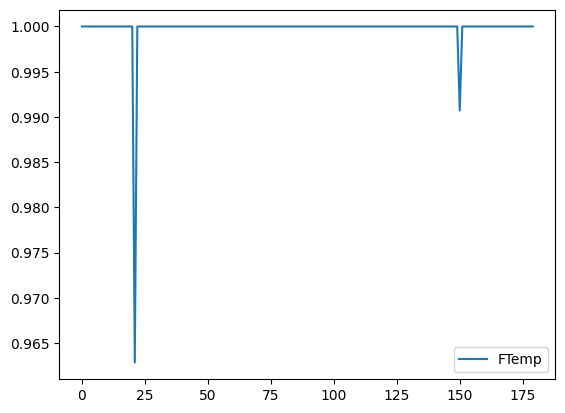

In [6]:
# fTemp(10,24,df['T2M'].tail(360).to_numpy()).plot()
fTemp(10,24,df['T2M'].to_numpy()).plot()

<Axes: >

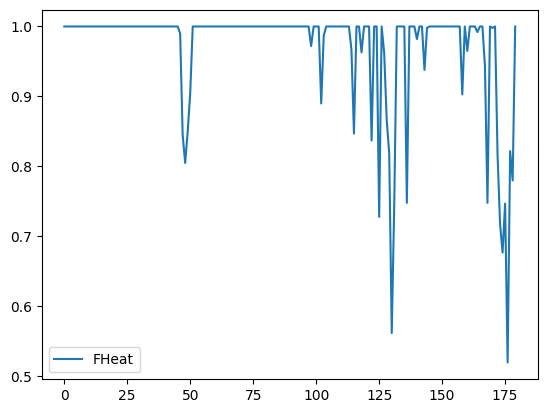

In [8]:
# fHeat(32,38,df['T2M_MAX'].tail(360).to_numpy()).plot()
fHeat(32,38,df['T2M_MAX'].to_numpy()).plot()

🔙 [Back to Section's header](#fheat) 

🔝 [Back to outline](#Out)

<a name="fSolar"></a>
### Function: fSolar


**Inputs:**
- fsolar: Solar factor (numeric)
- i50a: Parameter for growth (numeric)
- i50b: Parameter for senescence (numeric)
- tsum: Cumulative sum of temperatures (numeric)
- tbase: Base temperature (numeric)
- temp: List or array of temperature values (numeric)

**Overview:**
The `fSolar` function calculates the FSolar values based on the given temperature conditions and parameters. FSolar represents the solar factor, indicating the suitability of solar radiation for growth and senescence. The function calculates the temperature values based on tbase, performs cumulative sum calculations, calculates growth and senescence values, and determines the final FSolar value based on the growth and senescence values.

**Process:**
1. Calculate the temperature values based on tbase by taking the absolute difference and the average for each temperature value.
2. Initialize an empty list, `tt`, to store cumulative temperature values.
3. Iterate over the temperature values and calculate the cumulative sum, appending the values to `tt`. Set the first value to 0.0.
4. Calculate the growth values based on the cumulative temperature values using the solar factor and the growth parameter.
5. Calculate the senescence values based on the cumulative temperature values using the solar factor and the senescence parameter.
6. Determine the final FSolar value for each index by comparing the senescence and growth values. If senescence is greater than or equal to growth, take the growth value; otherwise, take the senescence value.
7. Return the FSolar values as a DataFrame with a single column named 'FSolar'.

**Outputs:**
- DataFrame: A pandas DataFrame containing the calculated FSolar values, with a single column named 'FSolar'. The DataFrame represents the solar factor for growth and senescence based on the given temperature conditions and parameters. Each value in the column indicates the suitability of solar radiation for the corresponding temperature value.

In [12]:
import math
import pandas as pd

def fSolar(fsolar, i50a, i50b, tsum, tbase, temp):
    temp = [(abs(i - tbase) + (i - tbase)) / 2 for i in temp]  # Calculate the temperature values based on tbase
    tt = []  # Initialize an empty list to store cumulative temperature values
    for i in range(len(temp)):
        if i == 0:
            tt.append(0.0)  # Append 0.0 for the first temperature value
        else:
            tt.append(temp[i] + tt[i-1])  # Calculate and append cumulative temperature values
    
    growth = [fsolar / (1 + math.exp(-0.01 * (i - i50a))) for i in tt]  # Calculate growth values
    senescence = [fsolar / (1 + math.exp(0.01 * (i - (tsum - i50b)))) for i in tt]  # Calculate senescence values
    
    result = [growth[i] if senescence[i] >= growth[i] else senescence[i] for i in range(len(senescence))]  # Determine final result based on growth and senescence values
    
    return pd.DataFrame(result, columns=['FSolar'])  # Return result as a DataFrame with a single column 'FSolar'


<Axes: >

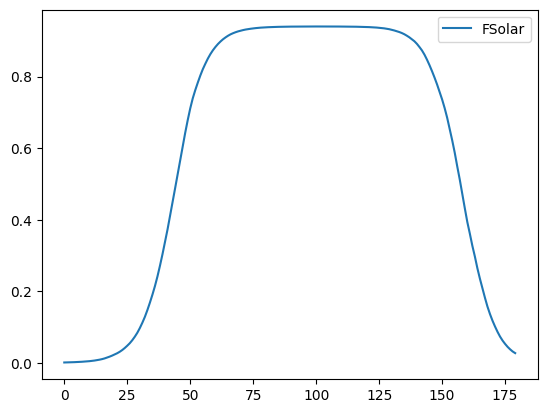

In [13]:
# fSolar(0.94,680,200,2764,10,df['T2M'].tail(360).to_numpy()).plot()

fSolar(0.94,680,200,2764,10,df['T2M'].to_numpy()).plot()


In [14]:
fSolar(0.94,680,200,2764,10,df['T2M'].to_numpy()).tail(10)

,FSolar
170,0.117851
171,0.101523
172,0.086571
173,0.073295
174,0.062221
175,0.052913
176,0.044627
177,0.037728
178,0.031729
179,0.027208


<a name="ETO"></a>
### Function for ETc calculation

**Inputs:**
- alfa: Albedo coefficient (numeric)
- RS: List or array of solar radiation values (numeric)
- RSO: List or array of clear sky solar radiation values (numeric)
- SIGMA: Stefan-Boltzmann constant (numeric)
- TMIN: List or array of minimum temperature values (numeric)
- TMAX: List or array of maximum temperature values (numeric)
- RHMEAN: List or array of mean relative humidity values (numeric)
- temp: List or array of average temperature values (numeric)
- Altitude: Altitude of the location (numeric)
- n: Psychrometric constant (numeric)
- E: Ratio of the molecular weight of water vapor to dry air (numeric)
- Cp: Specific heat capacity of air at constant pressure (numeric)
- G: Soil heat flux (numeric)
- WS2M: List or array of wind speed at 2 meters above the ground values (numeric)

**Overview:**
The `RN` function calculates the reference evapotranspiration (ETO) values based on the given inputs, including solar radiation, temperature, humidity, and other constants. The function follows the standard Penman-Monteith method to estimate ETO. It calculates various intermediate values such as vapor pressure, net radiation, slope of saturation vapor pressure curve, and air density, and combines them to compute the ETO.

**Process:**
1. Calculate vapor pressure at maximum temperature (eTMAX) using the maximum temperature values and the vapor pressure equation.
2. Calculate vapor pressure at minimum temperature (eTMIN) using the minimum temperature values and the vapor pressure equation.
3. Calculate actual vapor pressure (ea) as the mean relative humidity multiplied by the average of eTMAX and eTMIN.
4. Convert maximum temperature values to Kelvin (TMAXK) by adding 273.16.
5. Convert minimum temperature values to Kelvin (TMINK) by adding 273.16.
6. Calculate net shortwave radiation (RNS) as the product of (1 - alfa) and solar radiation.
7. Calculate net longwave radiation (RNL) using the Stefan-Boltzmann equation, humidity correction, and net solar radiation.
8. Calculate net radiation (RN) as the difference between RNS and RNL.
9. Calculate the slope of saturation vapor pressure curve (A) using the average temperature values.
10. Calculate the mean saturation vapor pressure (es) as the average of eTMAX and eTMIN.
11. Calculate the vapor pressure deficit (es_ea) as the difference between es and ea.
12. Calculate atmospheric pressure (P) using the altitude and the barometric pressure equation.
13. Calculate the psychrometric constant (y) using constants and atmospheric pressure.
14. Calculate the ETO using the Penman-Monteith equation and the intermediate values.
15. Adjust the ETO values using a coefficient (KS) to account for specific periods (multipliers for different periods).
16. Calculate the crop evapotranspiration (ETC) by multiplying the ETO values by the KS coefficients.

**Outputs:**
- ETO: List of reference evapotranspiration values calculated using the Penman-Monteith method. Each value represents the estimated evapotranspiration rate for the corresponding period.
- ETC: List of adjusted crop evapotranspiration values based on the ETO values and the period-specific coefficients (KS). Each value represents the estimated crop evapotranspiration rate for the corresponding period.

In [17]:
#We need the radiation function and the ETO function
#ETO function
import math
def RN(alfa,RS,RSO,SIGMA,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M):    
    eTMAX = [0.6108*math.exp((17.27*TMAX[i])/(TMAX[i]+237.3)) for i in range(len(TMAX))] #O
    eTMIN = [0.6108*math.exp((17.27*TMIN[i])/(TMIN[i]+237.3)) for i in range(len(TMIN))] #N
    ea = [(RHMEAN[i]/100)*((eTMAX[i]+eTMIN[i])/2) for i in range(len(RHMEAN))] #M
    TMAXK = [TMAX[i]+273.16 for i in range(len(TMAX))] #L
    TMINK = [TMIN[i]+273.16 for i in range(len(TMIN))] #J
    RNS = [(1-alfa)*RS[i] for i in range(len(RS))] #D
    RNL =[SIGMA*((TMINK[i]**4+TMAXK[i]**4)/2)*(0.34-0.14*(ea[i]**0.5))*(1.35*(RS[i]/RSO[i])-0.35) for i in range(len(TMIN))] #C
    RN = [RNS[i]-RNL[i] for i in range(len(TMIN))] #A
    A = [4098*(0.6108*math.exp(17.27*temp[i]/(temp[i]+237.3)))/(temp[i]+237.3)**2for i in range(len(temp))] #ETO R
    es = [(eTMAX[i]+eTMIN[i])/2 for i in range(len(TMIN))] #Eto P
    es_ea = [es[i]-ea[i] for i in range(len(temp))] #Eto M
    P = 101.3*((293-0.0065*Altitude)/293)**5.26 #Eto H
    y = ((Cp*P)/(n*E)) # Eto F
    ETO = [(0.408*A[i]*(RN[i]- G)+y*(900/(temp[i]+273))*WS2M[i]*(es_ea[i]))/(A[i]+y*(1+0.34*WS2M[i]))for i in range(len(temp))] #eto B 
    KS = [1]*(int(len(ETO)*5/18))+[1.05]*(int(len(ETO)*13/18)) #La igualo a longitud de ETO pero en el Excel aparece con longitud de 130 debo arreglarlo para múltiples periodos
    ETC = [KS[i]*ETO[i] for i in range(len(ETO))]
    return ETO, ETC
    


🔙 [Back to Section's header](#fSolar) 

🔝 [Back to outline](#Out)

<a name="fwater"></a>
### Function fWater

**Inputs:**
- Swater: Soil moisture depletion factor (numeric)
- TAW: Total available water (numeric)
- RAW: Readily available water (numeric)
- p: Fraction of RAW that can be easily depleted (numeric)
- alfa: Albedo coefficient (numeric)
- SIGMA: Stefan-Boltzmann constant (numeric)
- Precipitation: List or array of precipitation values (numeric)
- RS: List or array of solar radiation values (numeric)
- RSO: List or array of clear sky solar radiation values (numeric)
- TMIN: List or array of minimum temperature values (numeric)
- TMAX: List or array of maximum temperature values (numeric)
- RHMEAN: List or array of mean relative humidity values (numeric)
- temp: List or array of average temperature values (numeric)
- Altitude: Altitude of the location (numeric)
- n: Psychrometric constant (numeric)
- E: Ratio of the molecular weight of water vapor to dry air (numeric)
- Cp: Specific heat capacity of air at constant pressure (numeric)
- G: Soil heat flux (numeric)
- WS2M: List or array of wind speed at 2 meters above the ground values (numeric)
- la: Lower limit of depletion (numeric)
- S: Soil moisture storage (numeric)

**Overview:**
The `fWater` function calculates the water factor (FWater) based on the given inputs, including soil moisture, available water, precipitation, solar radiation, temperature, humidity, and other parameters. The function determines the water gain and water loss components, computes the water loss, depletion, and available water, and calculates the aridity factor (ARID) and the final water factor (FWater).

**Process:**
1. Call the `RN` function with the necessary inputs to obtain the reference evapotranspiration (ETO) values and the adjusted crop evapotranspiration (ETC) values.
2. Initialize lists for irrigation, capillary rise, and water gain, setting initial values to zero.
3. Calculate the water gain by summing the precipitation, irrigation, and capillary rise values for each time step.
4. Calculate the evaporated water based on the ETO values and a simplified condition. If precipitation is greater than or equal to 20% of the ETO value, evaporated water is 20% of the ETO; otherwise, it is equal to the precipitation.
5. Calculate the drain component based on the difference between precipitation and the lower limit of depletion (la), squared and divided by the sum of precipitation minus la and the soil moisture storage (S). If precipitation is greater than la, the drain component is nonzero; otherwise, it is zero.
6. Calculate the total water loss (WaterLoss_DP) by summing the ETC, drain, and evaporated components.
7. Initialize lists for depletion, lagged depletion, and plant available water (PAW), setting initial values to zero.
8. Calculate the depletion for each time step based on the water gain, water loss, and lagged depletion. If the difference between water loss, water gain, and lagged depletion is greater than zero, check if it exceeds the total available water (TAW). If it does, set the depletion to TAW; otherwise, set it to the difference. If the difference is less than or equal to zero, set the depletion to zero.
9. Calculate the plant available water (PAW) based on the difference between TAW and the depletion. If TAW is greater than the depletion, PAW is the difference; otherwise, PAW is zero.
10. Calculate the aridity factor (ARID) based on ETO

 and PAW, considering a minimum limit of 0.096 times PAW.
11. Calculate the final water factor (FWater) by subtracting Swater multiplied by ARID from 1 for each time step.

**Outputs:**
- DataFrame: A pandas DataFrame containing the calculated water factor (FWater) values, with a single column named 'FWater'. The DataFrame represents the availability of water for the corresponding time steps. Each value in the column indicates the suitability of water supply for the given conditions.

In [ ]:
def fWater(Swater, TAW,RAW,p, alfa, SIGMA, Precipitation,RS,RSO,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M,la,S):
    ETO , ETC = RN(alfa,RS,RSO,SIGMA,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M)
    #Water gain
    # Irrigation
    Irrigation = [0]*len(Precipitation)
    # Capillary Rise
    CapillaryRise = [0]*len(Precipitation)
    #Water gain
    WaterGain = [Precipitation[i] + Irrigation[i] +CapillaryRise[i] for i in range(len(Precipitation))]
    
    #Water Loss
    #Evaporated
    # Evaporated = [ ETO[i]*0.2 if Precipitation[i]> 0 and Precipitation[i]>= ETO[i]*0.2 else Precipitation[i] for i in range(len(Precipitation))]
    Evaporated = [ ETO[i]*0.2 if  Precipitation[i]>= ETO[i]*0.2 else Precipitation[i] for i in range(len(Precipitation))] #Simplyfied
    #Drain
    Drain = [((Precipitation[i]-la)**2)/(Precipitation[i]-la+S) if (Precipitation[i]>la) else 0 for i in range(len(Precipitation))]
    
    #Water Loss
    WaterLoss_DP = [ETC[i]+Drain[i]+Evaporated[i] for i in range(len(Precipitation))]
    #Depletion size
    Depletion = [0.0]*len(Precipitation)
    #Depletion lagged 1 step
    Depletion_lag = Depletion
    # for i in range(len(Depletion)):
    #     if i == 0:
    #         Depletion_lag[i]=0.0
    #     else:
    #         Depletion_lag[i]=Depletion[i-1]
    #Depletion
    for i in range(len(Depletion)):
        print
        if i==0:
            Depletion[i] = 0.0
            Depletion_lag[i] = 0.0

        else:
            Depletion_lag[i] = Depletion[i-1]
            if WaterLoss_DP[i]-WaterGain[i]+Depletion_lag[i]>0:
                if WaterLoss_DP[i]-WaterGain[i]+Depletion_lag[i]>TAW:
                    Depletion[i] = TAW
                    # Depletion_lag[i] = Depletion[i-1]
                else:
                    Depletion[i] = WaterLoss_DP[i]-WaterGain[i]+Depletion_lag[i]  
                    # Depletion_lag[i] = Depletion[i-1]
            else:
                Depletion[i] = 0
                
                
    #Paw
    PAW=[TAW-Depletion[i] if TAW > Depletion[i] else 0 for i in range(len(Depletion))]
    #Arid
    ARID = [1-min(ETO[i],0.096*PAW[i])/ETO[i] for i in range(len(PAW))]
    

    # return pd.DataFrame(ETC)
    return pd.DataFrame([1-Swater*ARID[i] for i in range(len(ARID))],columns = ['FWater'])

alfa = 0.23
RS = df['RS']
RSO = df['RSO']
SIGMA = 0.000000004903
TMIN = df['T2M_MIN']
TMAX = df['T2M_MAX']
RHMEAN = df['RH2M']
temp = (df['T2M_MIN']+df['T2M_MAX'])/2
Altitude = 658
n = 2.45
E = 0.622
Cp = 1.013/1000
G = 0
WS2M = df['WS2M']
Swater = 0.790164697774427
TAW = 140
RAW = 42
p = 0.3
Precipitation = df['PRECIPITATION']
S = 25400/77-254
la  = 0.2*(25400/77-254)
water = fWater(Swater, TAW,RAW,p, alfa, SIGMA, Precipitation,RS,RSO,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M,la,S)


### Example Calculation of fWater

The following code snippet demonstrates an example of calculating the water factor (FWater) using the `fWater` function with specific input values.

```python
#Example
alfa = 0.23
RS = df['RS']
RSO = df['RSO']
SIGMA = 0.000000004903
TMIN = df['T2M_MIN']
TMAX = df['T2M_MAX']
RHMEAN = df['RH2M']
temp = (df['T2M_MIN']+df['T2M_MAX'])/2
Altitude = 658
n = 2.45
E = 0.622
Cp = 1.013/1000
G = 0
WS2M = df['WS2M']
Swater = 0.790164697774427
TAW = 140
RAW = 42
p = 0.3
Precipitation = df['PRECIPITATION']
S = 25400/77-254
la  = 0.2*(25400/77-254)
water = fWater(Swater, TAW,RAW,p, alfa, SIGMA, Precipitation,RS,RSO,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M,la,S)
```


In [18]:
#Example
alfa = 0.23
RS = df['RS']
RSO = df['RSO']
SIGMA = 0.000000004903
TMIN = df['T2M_MIN']
TMAX = df['T2M_MAX']
RHMEAN = df['RH2M']
temp = (df['T2M_MIN']+df['T2M_MAX'])/2
Altitude = 658
n = 2.45
E = 0.622
Cp = 1.013/1000
G = 0
WS2M = df['WS2M']
Swater = 0.790164697774427
TAW = 140
RAW = 42
p = 0.3
Precipitation = df['PRECIPITATION']
S = 25400/77-254
la  = 0.2*(25400/77-254)
water = fWater(Swater, TAW,RAW,p, alfa, SIGMA, Precipitation,RS,RSO,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M,la,S)

<Axes: >

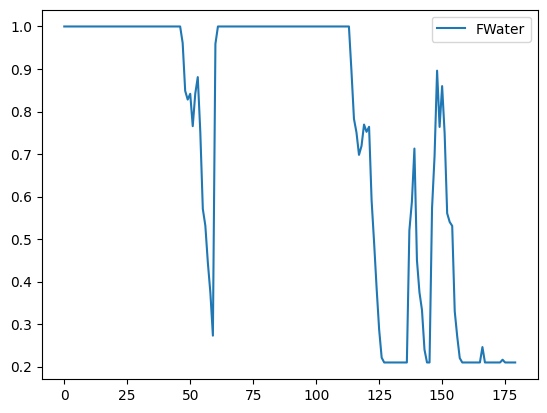

In [24]:
eto = RN(alfa,RS,RSO,SIGMA,TMIN,TMAX,RHMEAN,temp,Altitude,n,E,Cp,G,WS2M)
water.plot()

🔙 [Back to Section's header](#fwater) 

🔝 [Back to outline](#Out)